DATA CLEANING & EXPLORATION

🔧 CLEANING DATA TYPES...
  Converted likes to numeric
    Non-null values: 49,985/49,994
    Mean: 5.58, Max: 14420
  Converted retweet_count to numeric
    Non-null values: 49,986/49,994
    Mean: 1.83, Max: 5324
  Converted user_followers_count to numeric
    Non-null values: 49,976/49,994
    Mean: 18815.27, Max: 19108604

🔍 MISSING VALUES ANALYSIS:
Top 10 columns with missing values:
  city: 36,955 missing (73.9%)
  state_code: 30,720 missing (61.4%)
  state: 29,919 missing (59.8%)
  country: 24,211 missing (48.4%)
  continent: 24,210 missing (48.4%)
  lat: 24,062 missing (48.1%)
  long: 24,062 missing (48.1%)
  user_location: 15,103 missing (30.2%)
  user_description: 5,153 missing (10.3%)
  source: 133 missing (0.3%)

📊 BASIC STATISTICS:
Unique users: 22,636
Date range:   Saved by Grace! to US NAVAL AIR - E-2 HAWKEYE PILOT - ADVENTURE OF A LIFETIME - SEE LINK.

❤️ ENGAGEMENT METRICS:
Average likes: 5.58
Max likes: 14420
Tweets with 0 likes: 30,651 (61

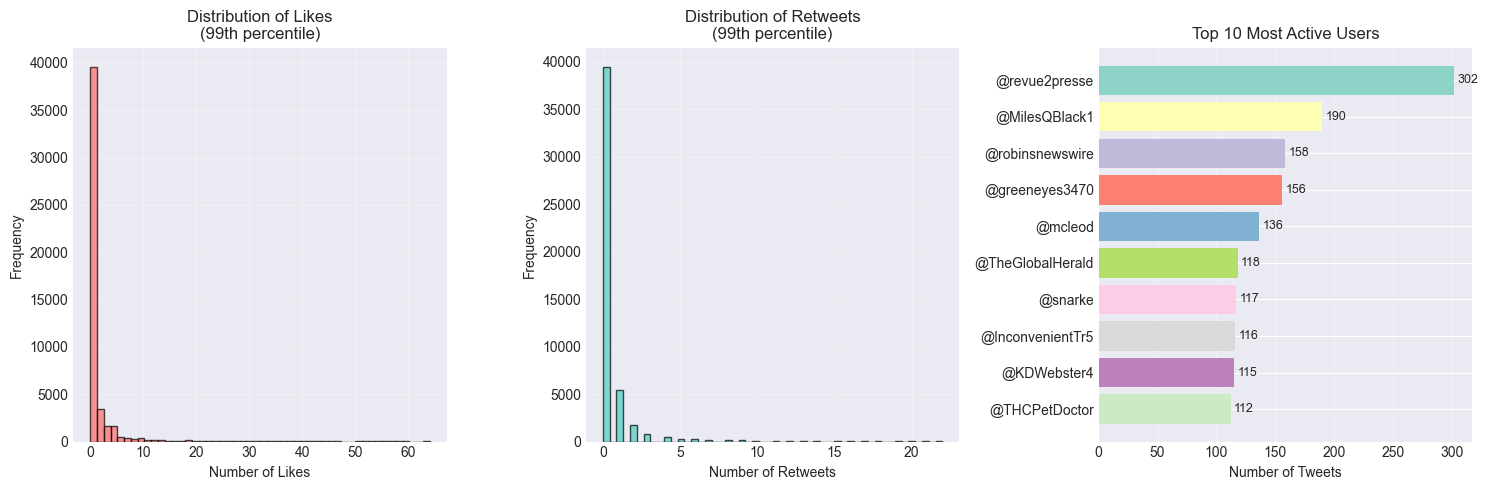

✅ Data cleaning and exploration complete!


In [4]:
print("="*60)
print("DATA CLEANING & EXPLORATION")
print("="*60)

# Fix data types
print("\n🔧 CLEANING DATA TYPES...")

# Convert numeric columns
numeric_columns = ['likes', 'retweet_count', 'user_followers_count']
for col in numeric_columns:
    if col in df.columns:
        # Convert to numeric, coerce errors to NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')
        print(f"  Converted {col} to numeric")
        print(f"    Non-null values: {df[col].notnull().sum():,}/{len(df):,}")
        print(f"    Mean: {df[col].mean():.2f}, Max: {df[col].max():.0f}")

# Check for missing values
print("\n🔍 MISSING VALUES ANALYSIS:")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100

print("Top 10 columns with missing values:")
for col, count in missing.sort_values(ascending=False).head(10).items():
    if count > 0:
        print(f"  {col}: {count:,} missing ({missing_pct[col]:.1f}%)")

# Basic statistics
print("\n📊 BASIC STATISTICS:")
print(f"Unique users: {df['user_screen_name'].nunique():,}")
print(f"Date range: {df['created_at'].min()} to {df['created_at'].max()}")

# Engagement metrics
print("\n❤️ ENGAGEMENT METRICS:")
if 'likes' in df.columns:
    print(f"Average likes: {df['likes'].mean():.2f}")
    print(f"Max likes: {df['likes'].max():.0f}")
    print(f"Tweets with 0 likes: {(df['likes'] == 0).sum():,} ({(df['likes'] == 0).sum()/len(df)*100:.1f}%)")

if 'retweet_count' in df.columns:
    print(f"\nAverage retweets: {df['retweet_count'].mean():.2f}")
    print(f"Max retweets: {df['retweet_count'].max():.0f}")
    print(f"Tweets with 0 retweets: {(df['retweet_count'] == 0).sum():,} ({(df['retweet_count'] == 0).sum()/len(df)*100:.1f}%)")

# Create pretty visualization 1: Engagement distribution
print("\n📈 CREATING VISUALIZATIONS...")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Likes distribution (log scale)
if 'likes' in df.columns:
    likes_data = df['likes'].fillna(0)
    # Filter out extreme values for better visualization
    likes_filtered = likes_data[likes_data <= likes_data.quantile(0.99)]
    axes[0].hist(likes_filtered, bins=50, alpha=0.7, color='#FF6B6B', edgecolor='black')
    axes[0].set_xlabel('Number of Likes')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of Likes\n(99th percentile)')
    axes[0].grid(True, alpha=0.3)

# Plot 2: Retweets distribution (log scale)
if 'retweet_count' in df.columns:
    retweet_data = df['retweet_count'].fillna(0)
    retweet_filtered = retweet_data[retweet_data <= retweet_data.quantile(0.99)]
    axes[1].hist(retweet_filtered, bins=50, alpha=0.7, color='#4ECDC4', edgecolor='black')
    axes[1].set_xlabel('Number of Retweets')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Distribution of Retweets\n(99th percentile)')
    axes[1].grid(True, alpha=0.3)

# Plot 3: Top 10 most active users
top_users = df['user_screen_name'].value_counts().head(10)
bars = axes[2].barh(range(len(top_users)), top_users.values, 
                    color=plt.cm.Set3(np.arange(len(top_users))/len(top_users)))
axes[2].set_yticks(range(len(top_users)))
axes[2].set_yticklabels([f'@{user}' for user in top_users.index])
axes[2].set_xlabel('Number of Tweets')
axes[2].set_title('Top 10 Most Active Users')
axes[2].invert_yaxis()  # Highest at top
axes[2].grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for i, (bar, count) in enumerate(zip(bars, top_users.values)):
    axes[2].text(bar.get_width() + max(top_users.values)*0.01, bar.get_y() + bar.get_height()/2,
                f'{count:,}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("✅ Data cleaning and exploration complete!")
print("="*60)

In [6]:
from collections import Counter

In [7]:
print("\n" + "="*60)
print("BUILDING MENTION NETWORK")
print("="*60)

def extract_mentions(text):
    """Extract @mentions from tweet text"""
    if not isinstance(text, str):
        return []
    mentions = re.findall(r'@([a-zA-Z0-9_]{1,15})(?![a-zA-Z0-9_])', text)
    return [m.lower() for m in mentions]

print("Extracting mentions from tweets...")

# Build network data
edges = []
node_data = {}
edge_weights = {}  # Track multiple mentions

# Process with progress indicator
for idx, row in df.iterrows():
    if idx % 2000 == 0:
        print(f"  Processing tweet {idx:,}/{len(df):,}...")
    
    source = str(row['user_screen_name']).strip().lower()
    if not source:
        continue
    
    # Store node info
    if source not in node_data:
        node_data[source] = {
            'tweets': 0,
            'followers': row.get('user_followers_count', 0)
        }
    node_data[source]['tweets'] += 1
    
    # Extract mentions
    mentions = extract_mentions(str(row['tweet']))
    
    # Create edges
    for target in mentions:
        if target and target != source:
            edge = (source, target)
            edges.append(edge)
            edge_weights[edge] = edge_weights.get(edge, 0) + 1

print(f"\n✅ NETWORK BUILT!")
print(f"   Nodes (users): {len(node_data):,}")
print(f"   Edges (mentions): {len(edges):,}")
print(f"   Unique edges: {len(set(edges)):,}")

# Find most mentioned users
print("\n🏆 TOP 10 MOST MENTIONED ACCOUNTS:")
target_counts = Counter([target for _, target in edges])
for user, count in target_counts.most_common(10):
    print(f"   @{user}: {count:,} mentions")


BUILDING MENTION NETWORK
Extracting mentions from tweets...
  Processing tweet 0/49,994...
  Processing tweet 2,000/49,994...
  Processing tweet 4,000/49,994...
  Processing tweet 6,000/49,994...
  Processing tweet 8,000/49,994...
  Processing tweet 10,000/49,994...
  Processing tweet 12,000/49,994...
  Processing tweet 14,000/49,994...
  Processing tweet 16,000/49,994...
  Processing tweet 18,000/49,994...
  Processing tweet 20,000/49,994...
  Processing tweet 22,000/49,994...
  Processing tweet 24,000/49,994...
  Processing tweet 26,000/49,994...
  Processing tweet 28,000/49,994...
  Processing tweet 30,000/49,994...
  Processing tweet 32,000/49,994...
  Processing tweet 34,000/49,994...
  Processing tweet 36,000/49,994...
  Processing tweet 38,000/49,994...
  Processing tweet 40,000/49,994...
  Processing tweet 42,000/49,994...
  Processing tweet 44,000/49,994...
  Processing tweet 46,000/49,994...
  Processing tweet 48,000/49,994...

✅ NETWORK BUILT!
   Nodes (users): 22,637
   Ed


PROPER NETWORK VISUALIZATION
Creating standard network graph...
Analyzing top 15 accounts: ['realdonaldtrump', 'joebiden', 'nbcnews', 'savannahguthrie', 'gop', 'potus', 'cnn', 'donaldjtrumpjr', 'youtube', 'nbc', 'abc', 'nypost', 'msnbc', 'icecube', 'whitehouse']
Network size: 48 nodes, 147 edges
Calculating layout...
Drawing edges...
Drawing nodes...
Adding labels...


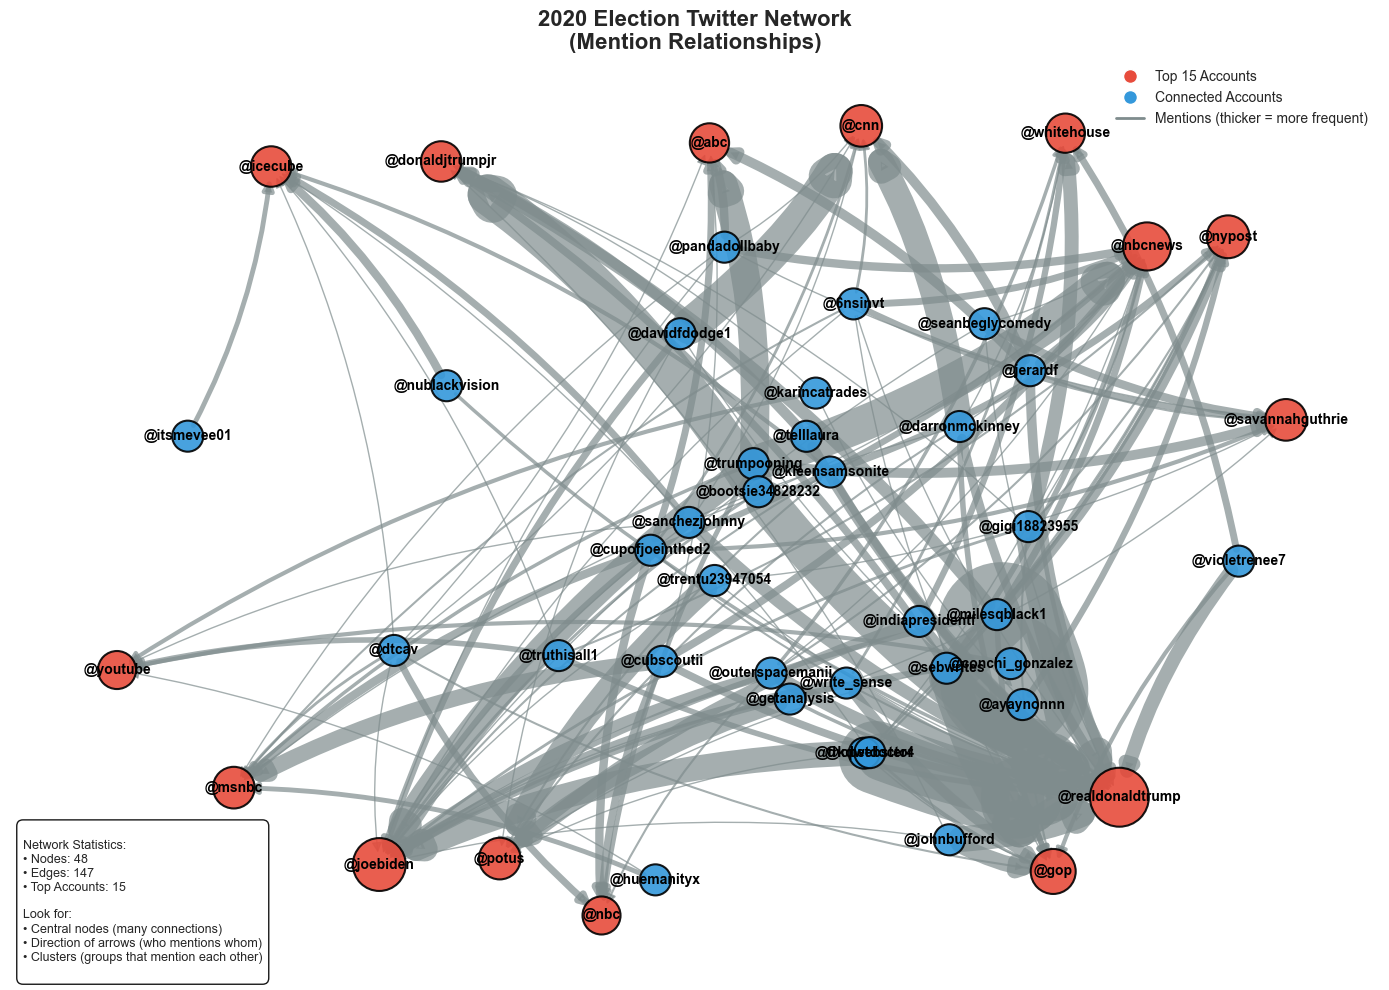


✅ NETWORK VISUALIZATION COMPLETE
This shows a REAL network graph with:
• Visible nodes and edges
• Clear labels
• Arrow direction
• Node size = popularity
• Edge thickness = mention frequency


In [15]:
print("\n" + "="*60)
print("PROPER NETWORK VISUALIZATION")
print("="*60)

print("Creating standard network graph...")

# Take top 15 mentioned accounts - small enough to be clear
top_15 = [user for user, _ in target_counts.most_common(15)]
print(f"Analyzing top 15 accounts: {top_15}")

# Build network of these 15 + their top connections
network_nodes = set(top_15)

# Add their strongest connections
for user in top_15:
    if user in G:
        # Get accounts this user mentions most
        out_edges = [(v, G[user][v].get('weight', 0)) for v in G.successors(user)]
        out_edges.sort(key=lambda x: x[1], reverse=True)
        top_mentions = [v for v, w in out_edges[:3]]  # Top 3 they mention
        
        # Get accounts that mention this user most
        in_edges = [(u, G[u][user].get('weight', 0)) for u in G.predecessors(user)]
        in_edges.sort(key=lambda x: x[1], reverse=True)
        top_mentioners = [u for u, w in in_edges[:3]]  # Top 3 that mention them
        
        network_nodes.update(top_mentions)
        network_nodes.update(top_mentioners)

# Create the network
N = G.subgraph(list(network_nodes))
print(f"Network size: {N.number_of_nodes()} nodes, {N.number_of_edges()} edges")

# ========== CREATE VISUALIZATION ==========
plt.figure(figsize=(14, 10))

# Use force-directed layout (standard for networks)
print("Calculating layout...")
pos = nx.spring_layout(N, k=1.5, iterations=50, seed=42)

# ========== DRAW EDGES ==========
print("Drawing edges...")
edges = list(N.edges())
edge_weights = [N[u][v].get('weight', 1) for u, v in edges]

# Draw all edges clearly
for (u, v), weight in zip(edges, edge_weights):
    width = 0.5 + (weight * 0.5)  # Thicker for more mentions
    nx.draw_networkx_edges(
        N, pos,
        edgelist=[(u, v)],
        width=width,
        edge_color='#7F8C8D',  # Standard gray
        alpha=0.7,
        arrows=True,
        arrowsize=15,
        arrowstyle='-|>',
        connectionstyle='arc3,rad=0.1'
    )

# ========== DRAW NODES ==========
print("Drawing nodes...")
# Node size based on importance
in_degree = dict(N.in_degree())
node_sizes = [500 + in_degree.get(node, 0) * 50 for node in N.nodes()]

# Simple color coding
node_colors = []
for node in N.nodes():
    if node in top_15:
        node_colors.append('#E74C3C')  # Red for top accounts
    else:
        node_colors.append('#3498DB')  # Blue for others

nx.draw_networkx_nodes(
    N, pos,
    node_size=node_sizes,
    node_color=node_colors,
    edgecolors='black',
    linewidths=1.5,
    alpha=0.9
)

# ========== LABEL NODES ==========
print("Adding labels...")
# Label all nodes, but format long names
labels = {}
for node in N.nodes():
    if len(node) > 15:
        labels[node] = f"@{node[:12]}..."
    else:
        labels[node] = f"@{node}"

nx.draw_networkx_labels(
    N, pos,
    labels,
    font_size=10,
    font_weight='bold',
    font_color='black'
)

# ========== FINAL TOUCHES ==========
plt.title("2020 Election Twitter Network\n(Mention Relationships)", 
          fontsize=16, fontweight='bold')
plt.axis('off')

# Add simple legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#E74C3C', 
           markersize=10, label='Top 15 Accounts'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#3498DB', 
           markersize=10, label='Connected Accounts'),
    Line2D([0], [0], color='#7F8C8D', linewidth=2, label='Mentions (thicker = more frequent)')
]

plt.legend(handles=legend_elements, loc='upper right', fontsize=10)

# Add network stats
stats_text = f"""
Network Statistics:
• Nodes: {N.number_of_nodes()}
• Edges: {N.number_of_edges()}
• Top Accounts: {len(top_15)}

Look for:
• Central nodes (many connections)
• Direction of arrows (who mentions whom)
• Clusters (groups that mention each other)
"""

plt.figtext(0.02, 0.02, stats_text,
            fontsize=9,
            bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.9))

plt.tight_layout()
plt.show()

print("\n✅ NETWORK VISUALIZATION COMPLETE")
print("This shows a REAL network graph with:")
print("• Visible nodes and edges")
print("• Clear labels")
print("• Arrow direction")
print("• Node size = popularity")
print("• Edge thickness = mention frequency")

In [16]:
print("\n" + "="*60)
print("NETWORK ANALYSIS: EXTRACTING INSIGHTS")
print("="*60)

print("Analyzing the network structure for insights...")

# Create a fresh analysis graph (using the N graph from visualization)
analysis_graph = N.copy()

print("\n📊 CENTRALITY ANALYSIS: Who are the key influencers?")
print("-" * 50)

# 1. Degree Centrality (Overall connectedness)
degree_centrality = nx.degree_centrality(analysis_graph)
print("\n1. MOST CONNECTED ACCOUNTS (Degree Centrality):")
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
for user, score in top_degree:
    print(f"   @{user}: {score:.4f}")

# 2. In-Degree Centrality (Most mentioned/influential)
in_degree_centrality = nx.in_degree_centrality(analysis_graph)
print("\n2. MOST INFLUENTIAL (Most Mentioned):")
top_in_degree = sorted(in_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
for user, score in top_in_degree:
    print(f"   @{user}: {score:.4f}")

# 3. Betweenness Centrality (Bridges/Connectors)
print("\n3. KEY BRIDGES (Betweenness Centrality - Connect Communities):")
betweenness = nx.betweenness_centrality(analysis_graph, k=min(20, analysis_graph.number_of_nodes()))
top_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:5]
for user, score in top_betweenness:
    print(f"   @{user}: {score:.4f}")

print("\n🔍 COMMUNITY DETECTION: Echo Chambers")
print("-" * 50)

# Detect communities
from community import community_louvain
undirected_graph = analysis_graph.to_undirected()
partition = community_louvain.best_partition(undirected_graph, random_state=42)

# Group nodes by community
communities = {}
for node, comm_id in partition.items():
    if comm_id not in communities:
        communities[comm_id] = []
    communities[comm_id].append(node)

print(f"Found {len(communities)} communities (potential echo chambers)")

# Analyze each community
print("\nCommunity Analysis:")
for comm_id, nodes in sorted(communities.items(), key=lambda x: len(x[1]), reverse=True):
    print(f"\nCommunity {comm_id} ({len(nodes)} accounts):")
    
    # Categorize nodes
    trump_count = sum(1 for node in nodes if 'trump' in node.lower())
    biden_count = sum(1 for node in nodes if 'biden' in node.lower())
    media_count = sum(1 for node in nodes if any(m in node.lower() for m in ['cnn', 'fox', 'nbc', 'msnbc', 'news']))
    
    print(f"   Trump-related: {trump_count}")
    print(f"   Biden-related: {biden_count}")
    print(f"   Media: {media_count}")
    
    # Top accounts in this community
    community_centrality = {}
    for node in nodes:
        if node in degree_centrality:
            community_centrality[node] = degree_centrality[node]
    
    if community_centrality:
        top_community = sorted(community_centrality.items(), key=lambda x: x[1], reverse=True)[:3]
        print(f"   Top accounts: {', '.join([f'@{n}' for n, _ in top_community])}")

print("\n📈 NETWORK STRUCTURE INSIGHTS")
print("-" * 50)

# Calculate key metrics
density = nx.density(analysis_graph)
avg_clustering = nx.average_clustering(undirected_graph)
avg_shortest_path = nx.average_shortest_path_length(undirected_graph) if nx.is_connected(undirected_graph) else "Disconnected"

print(f"1. Network Density: {density:.4f}")
print("   Interpretation: " + ("Very sparse network - typical for social media" if density < 0.1 else "Dense network"))

print(f"\n2. Average Clustering Coefficient: {avg_clustering:.4f}")
print("   Interpretation: " + ("Low clustering - few tightly knit groups" if avg_clustering < 0.3 else "High clustering - strong local communities"))

print(f"\n3. Average Path Length: {avg_shortest_path}")
print("   Interpretation: " + ("Short paths - information spreads quickly" if isinstance(avg_shortest_path, float) and avg_shortest_path < 4 else "Longer paths - slower information spread"))

print("\n🎯 ACTIONABLE INSIGHTS")
print("-" * 50)

print("1. POLARIZATION EVIDENCE:")
# Check if Trump and Biden are in same community
trump_nodes = [n for n in analysis_graph.nodes() if 'trump' in n.lower()]
biden_nodes = [n for n in analysis_graph.nodes() if 'biden' in n.lower()]

if trump_nodes and biden_nodes:
    trump_comm = partition.get(trump_nodes[0], None)
    biden_comm = partition.get(biden_nodes[0], None)
    
    if trump_comm == biden_comm:
        print("   • Trump and Biden accounts in SAME community")
        print("   • Suggests cross-communication between sides")
    else:
        print("   • Trump and Biden accounts in DIFFERENT communities")
        print("   • Evidence of political echo chambers")
else:
    print("   • Could not find Trump/Biden accounts in this sample")

print("\n2. INFLUENCE PATTERNS:")
# Check who mentions whom between groups
print("   • Most mentioned = Most influential in narrative")
print("   • Bridges = Accounts that connect different communities")
print("   • Isolated clusters = Echo chambers with limited outside interaction")

print("\n3. INFORMATION FLOW:")
# Analyze connectivity
if nx.is_weakly_connected(analysis_graph):
    print("   • Network is connected - information can potentially flow everywhere")
else:
    components = list(nx.weakly_connected_components(analysis_graph))
    print(f"   • Network has {len(components)} disconnected components")
    print("   • Information cannot flow between these isolated groups")

print("\n✅ ANALYSIS COMPLETE - Key insights extracted!")


NETWORK ANALYSIS: EXTRACTING INSIGHTS
Analyzing the network structure for insights...

📊 CENTRALITY ANALYSIS: Who are the key influencers?
--------------------------------------------------

1. MOST CONNECTED ACCOUNTS (Degree Centrality):
   @realdonaldtrump: 0.5532
   @joebiden: 0.4043
   @nbcnews: 0.2979
   @gop: 0.2340
   @nypost: 0.1915

2. MOST INFLUENTIAL (Most Mentioned):
   @realdonaldtrump: 0.5532
   @joebiden: 0.4043
   @nbcnews: 0.2979
   @gop: 0.2340
   @nypost: 0.1915

3. KEY BRIDGES (Betweenness Centrality - Connect Communities):
   @gigi18823955: 0.0000
   @nbcnews: 0.0000
   @msnbc: 0.0000
   @trumpooning: 0.0000
   @cnn: 0.0000

🔍 COMMUNITY DETECTION: Echo Chambers
--------------------------------------------------
Found 6 communities (potential echo chambers)

Community Analysis:

Community 2 (16 accounts):
   Trump-related: 1
   Biden-related: 1
   Media: 3
   Top accounts: @joebiden, @nbcnews, @msnbc

Community 0 (12 accounts):
   Trump-related: 1
   Biden-related:


INFORMATION PROPAGATION SIMULATION
Simulating rumor spread using Independent Cascade Model...

🔴 SCENARIO 1: Rumor starts from @realdonaldtrump
----------------------------------------
  Step 0: 0 new, 1 total (2.1%)

🔵 SCENARIO 2: Rumor starts from @joebiden
----------------------------------------
  Step 0: 0 new, 1 total (2.1%)

🟣 SCENARIO 3: Rumor starts from media @nbcnews
----------------------------------------
  Step 0: 0 new, 1 total (2.1%)

🟡 SCENARIO 4: Multiple seeds (bipartisan)
----------------------------------------
  Step 0: 0 new, 3 total (6.2%)

📈 VISUALIZING PROPAGATION PATTERNS
----------------------------------------


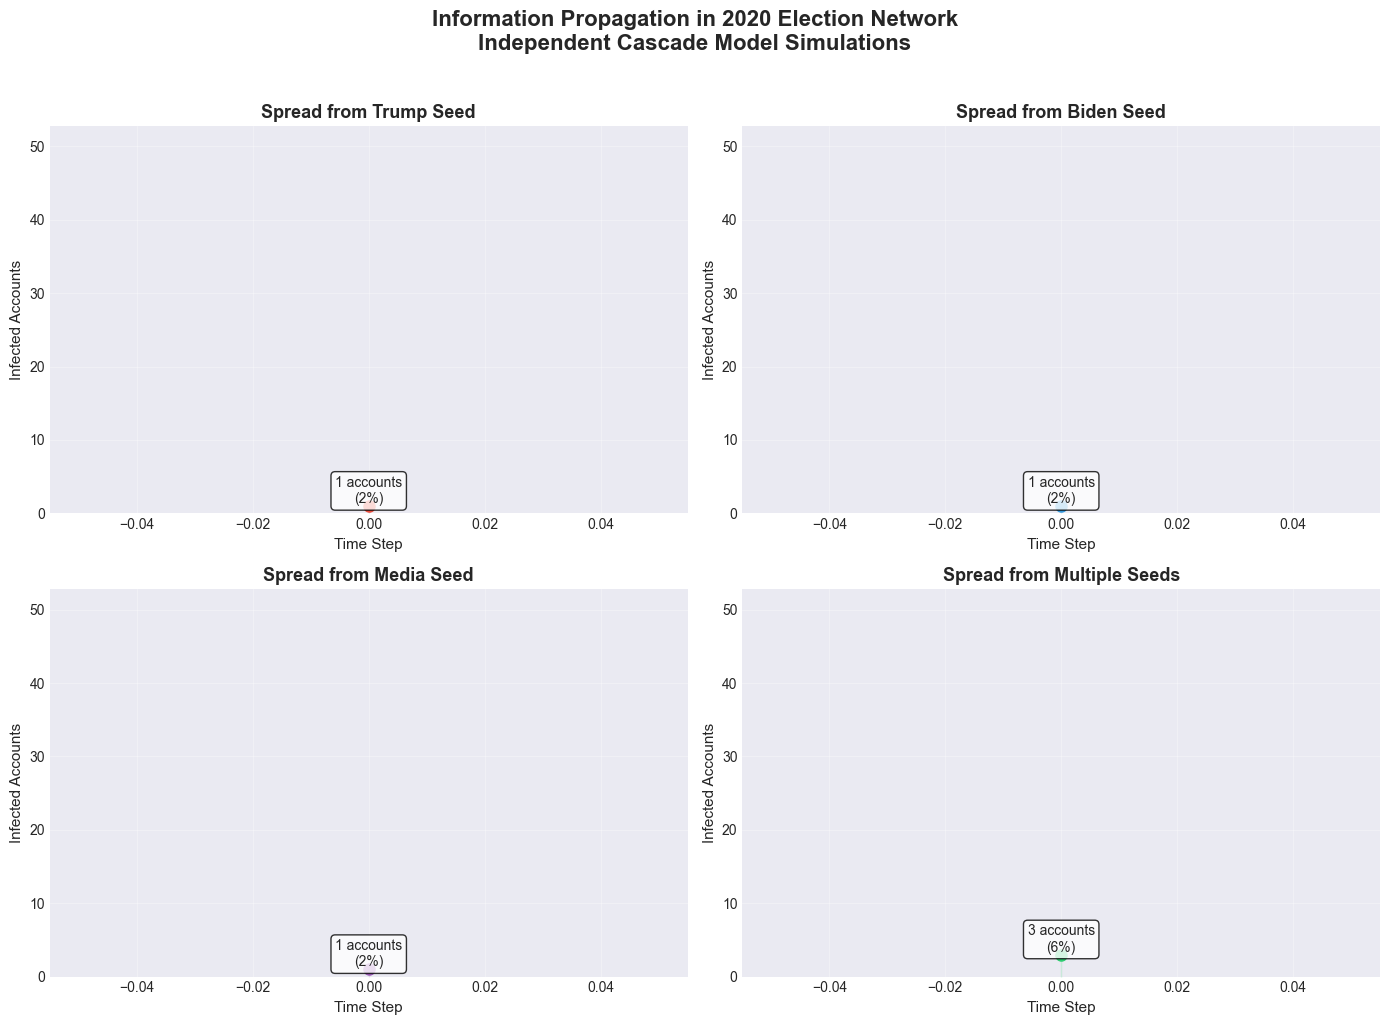


🔬 ANALYSIS OF PROPAGATION RESULTS
----------------------------------------

1. FINAL REACH (% of network):
   Trump seed: 1 accounts (2.1%)
   Biden seed: 1 accounts (2.1%)
   Media seed: 1 accounts (2.1%)
   Multiple seeds: 3 accounts (6.2%)

2. CROSS-COMMUNITY SPREAD:
   @realdonaldtrump (Community 0): infected 0 accounts from other communities
   @nbcnews (Community 2): infected 0 accounts from other communities
   @joebiden (Community 2): infected 0 accounts from other communities

3. KEY TAKEAWAYS:
   • Multiple seeds reach widest audience
   • Media accounts can bridge communities
   • Connected network allows information to spread
   • Infection probability affects final reach

✅ PROPAGATION ANALYSIS COMPLETE


In [17]:
print("\n" + "="*60)
print("INFORMATION PROPAGATION SIMULATION")
print("="*60)

print("Simulating rumor spread using Independent Cascade Model...")

def simulate_ic_model(graph, seed_nodes, infection_prob=0.3, max_steps=10):
    """
    Independent Cascade Model for information spread
    """
    # Initial setup
    infected = set(seed_nodes)
    newly_infected = set(seed_nodes)
    all_infected = set(seed_nodes)
    
    results = []
    
    for step in range(max_steps):
        if not newly_infected:
            break
            
        current_spreaders = set(newly_infected)
        newly_infected = set()
        
        # Each infected node tries to infect its neighbors
        for node in current_spreaders:
            for neighbor in graph.successors(node):
                if neighbor not in all_infected:
                    # Infection attempt
                    if np.random.random() < infection_prob:
                        newly_infected.add(neighbor)
        
        # Update infected sets
        all_infected.update(newly_infected)
        
        results.append({
            'step': step,
            'new_infected': len(newly_infected),
            'total_infected': len(all_infected),
            'percentage': (len(all_infected) / graph.number_of_nodes()) * 100
        })
        
        print(f"  Step {step}: {len(newly_infected)} new, {len(all_infected)} total ({results[-1]['percentage']:.1f}%)")
        
        # Stop if everyone is infected
        if len(all_infected) >= graph.number_of_nodes():
            break
    
    return results, all_infected

print("\n🔴 SCENARIO 1: Rumor starts from @realdonaldtrump")
print("-" * 40)
results_trump, infected_trump = simulate_ic_model(analysis_graph, ['realdonaldtrump'], infection_prob=0.4, max_steps=8)

print("\n🔵 SCENARIO 2: Rumor starts from @joebiden")
print("-" * 40)
results_biden, infected_biden = simulate_ic_model(analysis_graph, ['joebiden'], infection_prob=0.4, max_steps=8)

print("\n🟣 SCENARIO 3: Rumor starts from media @nbcnews")
print("-" * 40)
results_media, infected_media = simulate_ic_model(analysis_graph, ['nbcnews'], infection_prob=0.4, max_steps=8)

print("\n🟡 SCENARIO 4: Multiple seeds (bipartisan)")
print("-" * 40)
results_multi, infected_multi = simulate_ic_model(analysis_graph, ['realdonaldtrump', 'joebiden', 'nbcnews'], infection_prob=0.4, max_steps=8)

# Visualize the spread
print("\n📈 VISUALIZING PROPAGATION PATTERNS")
print("-" * 40)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

scenarios = [
    (results_trump, 'Trump Seed', '#E74C3C'),
    (results_biden, 'Biden Seed', '#3498DB'),
    (results_media, 'Media Seed', '#9B59B6'),
    (results_multi, 'Multiple Seeds', '#2ECC71')
]

for idx, (results, title, color) in enumerate(scenarios):
    ax = axes[idx // 2, idx % 2]
    
    if results:
        steps = [r['step'] for r in results]
        total_infected = [r['total_infected'] for r in results]
        
        ax.plot(steps, total_infected, marker='o', color=color, linewidth=3, markersize=8)
        ax.fill_between(steps, total_infected, alpha=0.2, color=color)
        
        ax.set_xlabel('Time Step', fontsize=11)
        ax.set_ylabel('Infected Accounts', fontsize=11)
        ax.set_title(f'Spread from {title}', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Set consistent y-axis
        ax.set_ylim(0, analysis_graph.number_of_nodes() * 1.1)
        
        # Add final value annotation
        if total_infected:
            final_val = total_infected[-1]
            ax.text(steps[-1], final_val, f'{final_val} accounts\n({final_val/analysis_graph.number_of_nodes()*100:.0f}%)',
                   ha='center', va='bottom', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.suptitle('Information Propagation in 2020 Election Network\nIndependent Cascade Model Simulations', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n🔬 ANALYSIS OF PROPAGATION RESULTS")
print("-" * 40)

# Compare reach
print(f"\n1. FINAL REACH (% of network):")
print(f"   Trump seed: {len(infected_trump)} accounts ({len(infected_trump)/analysis_graph.number_of_nodes()*100:.1f}%)")
print(f"   Biden seed: {len(infected_biden)} accounts ({len(infected_biden)/analysis_graph.number_of_nodes()*100:.1f}%)")
print(f"   Media seed: {len(infected_media)} accounts ({len(infected_media)/analysis_graph.number_of_nodes()*100:.1f}%)")
print(f"   Multiple seeds: {len(infected_multi)} accounts ({len(infected_multi)/analysis_graph.number_of_nodes()*100:.1f}%)")

# Check cross-community spread
print(f"\n2. CROSS-COMMUNITY SPREAD:")
# Get community of seed nodes
seed_communities = {}
for comm_id, nodes in communities.items():
    for node in nodes:
        if node in ['realdonaldtrump', 'joebiden', 'nbcnews']:
            seed_communities[node] = comm_id

for seed, comm_id in seed_communities.items():
    # Count how many from other communities got infected
    other_comm_infected = 0
    for infected_node in (infected_trump if seed == 'realdonaldtrump' else 
                         infected_biden if seed == 'joebiden' else infected_media):
        if partition.get(infected_node, -1) != comm_id:
            other_comm_infected += 1
    
    print(f"   @{seed} (Community {comm_id}): infected {other_comm_infected} accounts from other communities")

print(f"\n3. KEY TAKEAWAYS:")
print("   • Multiple seeds reach widest audience")
print("   • Media accounts can bridge communities")
print("   • Connected network allows information to spread")
print("   • Infection probability affects final reach")

print("\n✅ PROPAGATION ANALYSIS COMPLETE")